# Import Libraries and Data

In [1]:
import pandas as pd
import pandas as pd
import seaborn as sns
import xgboost
import shap
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

from imblearn.over_sampling import SMOTE
from shap import Explainer
from shap.plots import beeswarm

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_precision_recall_curve
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import RocCurveDisplay, auc
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
from sklearn import metrics

import warnings
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")


Import data-no headers and I left the index_col out so I would have a list of consecutive numbers.

In [2]:
df= pd.read_csv('./data/wdbc.data',  index_col= None, header = None, na_values='?')
#df.head(2)

Took a look at the data.  Note there are no headers, I found in the names.data file a list of the columns.  I then renamed the columns per this list:

There are ten real-valued features computed for each cell nucleus :

1. radius (mean of distances from center to points on the perimeter)
2. texture (standard deviation of gray-scale values)
3. perimeter
4. area
5. smoothness (local variation in radius lengths)
6. compactness (perimeter² / area — 1.0)
7. concavity (severity of concave portions of the contour)
8. concave points (number of concave portions of the contour)
9. symmetry
10. fractal dimension (“coastline approximation” — 1)

The mean, standard error and “worst” or largest (mean of the three largest values) of these features were computed for each image, resulting in 30 features.

In [3]:
names = ['id','diagnosis','radius_mean','texture_mean','perimeter_mean','area_mean','smoothness_mean','compactness_mean','concavity_mean','concave_points_mean','symmetry_mean','fractal_dimension_mean','radius_se','texture_se','perimeter_se','area_se','smoothness_se','compactness_se','concavity_se','concave_points_se','symmetry_se','fractal_dimension_se','radius_worst','texture_worst','perimeter_worst','area_worst','smoothness_worst','compactness_worst','concavity_worst','concave_points_worst','symmetry_worst','fractal_dimension_worst']
df.columns = names
df.head()

id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave_points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  radius_worst  texture_worst  perimeter_worst  area_worst  \
0  ...         25.38          17.33           184.60      2019.0   
1  ...         24.99          23.41           158.80      1956.0   
2  ...         23.57          25.53           152.50      1709.0   
3  ...         14.91          26.50            98.87       567.7   
4  ...         22.54          16.67           152.20      1575.0   

   smoothness_worst  compactness_worst  concavity_worst  concave_points_worst  \
0            0.1622             0.6656           0.7119                0.2654   
1            0.1238             0.1866           0.2416                0.1860   
2            0.1444             0.4245           0.4504                0.2430   
3            0.2098             0.8663           0.6869                0.2575   
4            0.1374             0.2050           0.4000                0.1625   

   symmetry_worst  fractal_dimension_worst  
0          0.4601                  0.11890  
1          0.2750                  0.08902  
2          0.3613                  0.08758  
3          0.6638                  0.17300  
4          0.2364                  0.07678  

[5 rows x 32 columns]

In [4]:
#data looks complete (no empty lines at end).
df.tail(2)

id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
567  927241         M        20.60         29.33          140.10     1265.0   
568   92751         B         7.76         24.54           47.92      181.0   

     smoothness_mean  compactness_mean  concavity_mean  concave_points_mean  \
567          0.11780           0.27700          0.3514                0.152   
568          0.05263           0.04362          0.0000                0.000   

     ...  radius_worst  texture_worst  perimeter_worst  area_worst  \
567  ...        25.740          39.42           184.60      1821.0   
568  ...         9.456          30.37            59.16       268.6   

     smoothness_worst  compactness_worst  concavity_worst  \
567           0.16500            0.86810           0.9387   
568           0.08996            0.06444           0.0000   

     concave_points_worst  symmetry_worst  fractal_dimension_worst  
567                 0.265          0.4087                  0.12400  
568                 0.000          0.2871                  0.07039  

[2 rows x 32 columns]

In [5]:
#Our dataset is imbalanced.  There are more benign outcomes than malignant.

counts=df["diagnosis"].value_counts()
counts

B    357
M    212
Name: diagnosis, dtype: int64

In [6]:
df['diagnosis'] = pd.factorize(df['diagnosis'])[0]

In [7]:
counts=df["diagnosis"].value_counts()
counts

1    357
0    212
Name: diagnosis, dtype: int64

In [8]:
#export factorised dataset so I can use in streamlit
df.to_csv('./data/dataset_factorised.csv')

# Defining Functions

In [9]:
def ml_function(model, X_train_data, y_train_data, X_test_data, y_test_data):
    model.fit(X_train_data, y_train_data)
    y_train_pred = model.predict(X_train_data)
    results_model_train = pd.DataFrame({
        'Score': ['accuracy', 'precision', 'recall', 'f1'],
        'Results': [model.score(X_train_data, y_train_pred), precision_score(y_train_data, y_train_pred), recall_score(y_train_data, y_train_pred), f1_score(y_train_data, y_train_pred)]})
    print("Training Scores")
    print(results_model_train)
    conf_model = confusion_matrix(y_train_data, y_train_pred)
    plot_heatmap(conf_model)
    y_test_pred = model.predict(X_test_data)
    
    results_model_test = pd.DataFrame({
        'Score': ['accuracy', 'precision', 'recall', 'f1'],
        'Results': [model.score(X_test_data, y_test_pred), precision_score(y_test_data, y_test_pred), recall_score(y_test_data, y_test_pred), f1_score(y_test_data, y_test_pred)]})
    print("Test Scores")
    print(results_model_test)
    
    fpr, tpr, thresholds = metrics.roc_curve(y_test_data, y_test_pred)
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
    display.plot()
    plt.title('ROC Curve on Test Data')
    plt.show()
    print("The ROC and AUC are run on the test data after the model has been trained.")

    precision, recall, _ = precision_recall_curve(y_test, y_test_pred)
    disp = PrecisionRecallDisplay(precision=precision, recall=recall)
    disp.plot()
    plt.title('Precision-Recall Curve on Test Data')
    plt.show()


In [10]:
bins = 20
def histplot(features):
  plt.figure(figsize=(10,15))
  for i, feature in enumerate(features):
      plt.subplot(5, 2, i+1)  #subplot function: the number of rows are given as 5 and number of columns as 2, the value i+1 gives the subplot number
      sns.histplot(Malignant[feature], bins=bins, color='red', alpha=0.7, label='Malignant');
      sns.histplot(Benign[feature], bins=bins, color='blue', alpha=0.7, label='Benign');
      plt.title(str(' Density Plot of: ')+str(feature))
      plt.xlabel(str(feature))
      plt.ylabel('Count')
      plt.legend(loc='upper right')
  plt.tight_layout()
  plt.show()

In [11]:
def plot_heatmap(confusion):
    
    plt.figure(figsize=(6,5))
    sns.heatmap(confusion,
                xticklabels = np.unique(y),
                yticklabels = np.unique(y),
                cmap = 'RdPu',
                annot=True,
                fmt='g'
                )

    # fmt is used to switch off scientific notation
    plt.xlabel('Predicted', fontsize=14)
    plt.ylabel('Actual', fontsize = 14)
    plt.title("Confusion Matrix")
#    plt.savefig("./images/rfc_feature_elim_confusion_matrix.png")
#    plt.savefig("./images/lr_feature_elim_confusion_matrix.png")
#    plt.savefig("./images/svm_feature_elim_confusion_matrix.png")
#    plt.savefig("./images/em_feature_elim_confusion_matrix.png")

# Exploratory Data Analysis

In [12]:
#We have 569 records of patients with 32 columns of data provided.
df.shape

(569, 32)

For EDA purposes, I will only use the mean values for graphing

In [13]:
#checked to see if there were any data types needing 
#conversion or missing data. There shouldn't be any missing, 
#as it stated it was a complete dataset.  All are ok per below.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    int64  
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave_points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [14]:
#looking for unique values, there are 569 unique id #'s
#and other measurements are mostly unique as expected.
unique = df.nunique()
unique

id                         569
diagnosis                    2
radius_mean                456
texture_mean               479
perimeter_mean             522
area_mean                  539
smoothness_mean            474
compactness_mean           537
concavity_mean             537
concave_points_mean        542
symmetry_mean              432
fractal_dimension_mean     499
radius_se                  540
texture_se                 519
perimeter_se               533
area_se                    528
smoothness_se              547
compactness_se             541
concavity_se               533
concave_points_se          507
symmetry_se                498
fractal_dimension_se       545
radius_worst               457
texture_worst              511
perimeter_worst            514
area_worst                 544
smoothness_worst           411
compactness_worst          529
concavity_worst            539
concave_points_worst       492
symmetry_worst             500
fractal_dimension_worst    535
dtype: i

In [15]:
#Check for duplicated patient info.  There isn't any to deal with.
duplications = df.duplicated().sum()
duplications

0

In [16]:
#divide the data into 2 classes
Malignant=df[df['diagnosis'] == 0]
Benign=df[df['diagnosis'] == 1]

In [17]:
#divide feature names into groups
mean_features= ['radius_mean','texture_mean','perimeter_mean',\
                'area_mean','smoothness_mean','compactness_mean',\
                'concavity_mean','concave_points_mean','symmetry_mean',\
                'fractal_dimension_mean']
error_features=['radius_se','texture_se','perimeter_se',\
                'area_se','smoothness_se','compactness_se',\
                'concavity_se','concave_points_se','symmetry_se',\
                'fractal_dimension_se']
worst_features=['radius_worst','texture_worst','perimeter_worst',\
                'area_worst','smoothness_worst','compactness_worst',\
                'concavity_worst','concave_points_worst',\
                'symmetry_worst','fractal_dimension_worst']

In [18]:
df_mean = df[['diagnosis','radius_mean','texture_mean','perimeter_mean','area_mean','smoothness_mean','compactness_mean','concavity_mean','concave_points_mean','symmetry_mean','fractal_dimension_mean']]

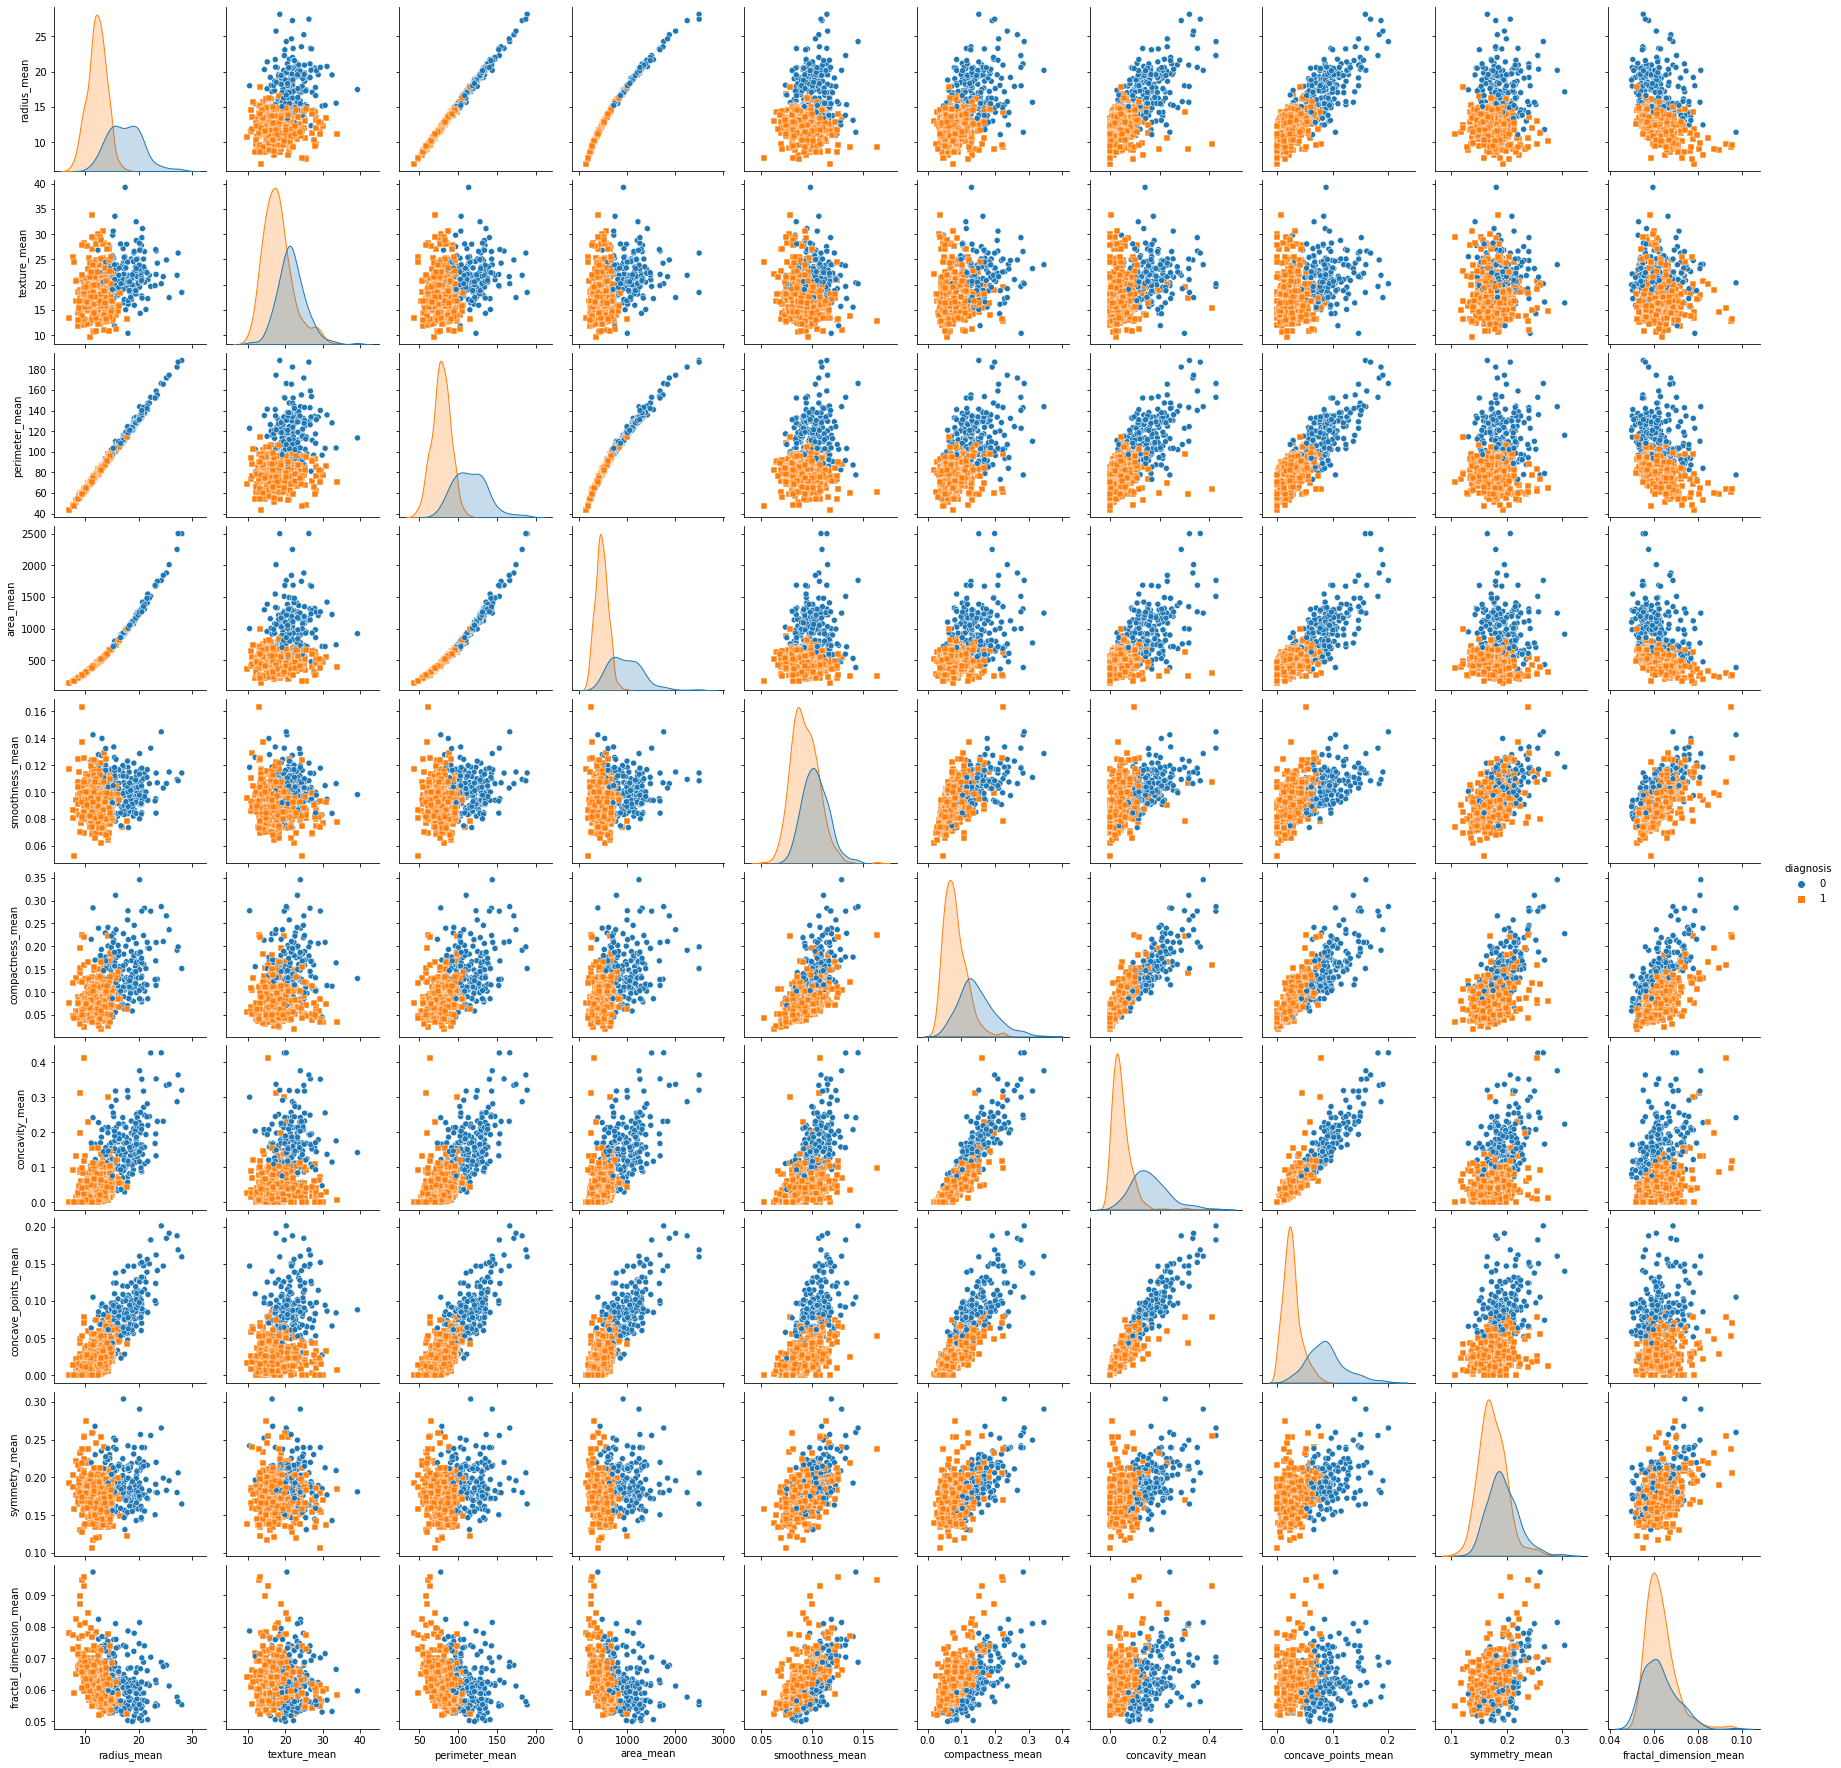

In [19]:
#There is a clear pattern between malignant and benign (2 clear clusters). 
sns.pairplot(df_mean, hue='diagnosis', markers=["o", "s"])
#Benign is orange, malignant is blue.

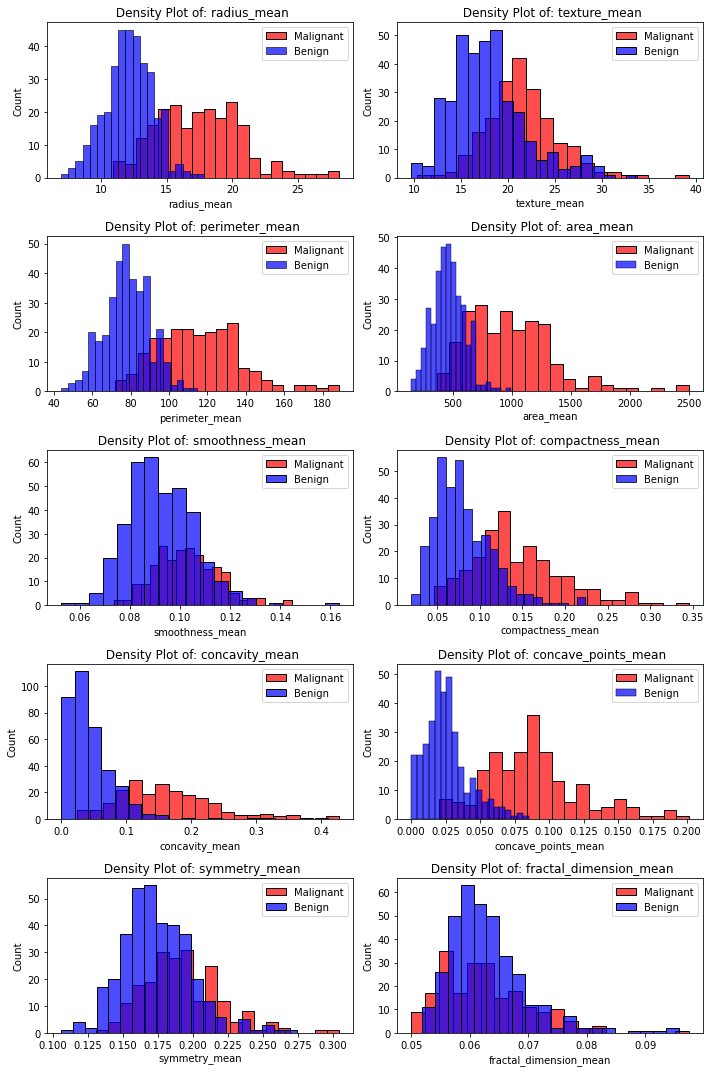

In [20]:
histplot(mean_features)

In [21]:
df[mean_features].describe()

radius_mean  texture_mean  perimeter_mean    area_mean  \
count   569.000000    569.000000      569.000000   569.000000   
mean     14.127292     19.289649       91.969033   654.889104   
std       3.524049      4.301036       24.298981   351.914129   
min       6.981000      9.710000       43.790000   143.500000   
25%      11.700000     16.170000       75.170000   420.300000   
50%      13.370000     18.840000       86.240000   551.100000   
75%      15.780000     21.800000      104.100000   782.700000   
max      28.110000     39.280000      188.500000  2501.000000   

       smoothness_mean  compactness_mean  concavity_mean  concave_points_mean  \
count       569.000000        569.000000      569.000000           569.000000   
mean          0.096360          0.104341        0.088799             0.048919   
std           0.014064          0.052813        0.079720             0.038803   
min           0.052630          0.019380        0.000000             0.000000   
25%           0.086370          0.064920        0.029560             0.020310   
50%           0.095870          0.092630        0.061540             0.033500   
75%           0.105300          0.130400        0.130700             0.074000   
max           0.163400          0.345400        0.426800             0.201200   

       symmetry_mean  fractal_dimension_mean  
count     569.000000              569.000000  
mean        0.181162                0.062798  
std         0.027414                0.007060  
min         0.106000                0.049960  
25%         0.161900                0.057700  
50%         0.179200                0.061540  
75%         0.195700                0.066120  
max         0.304000                0.097440

In [22]:
df[error_features].describe()

radius_se  texture_se  perimeter_se     area_se  smoothness_se  \
count  569.000000  569.000000    569.000000  569.000000     569.000000   
mean     0.405172    1.216853      2.866059   40.337079       0.007041   
std      0.277313    0.551648      2.021855   45.491006       0.003003   
min      0.111500    0.360200      0.757000    6.802000       0.001713   
25%      0.232400    0.833900      1.606000   17.850000       0.005169   
50%      0.324200    1.108000      2.287000   24.530000       0.006380   
75%      0.478900    1.474000      3.357000   45.190000       0.008146   
max      2.873000    4.885000     21.980000  542.200000       0.031130   

       compactness_se  concavity_se  concave_points_se  symmetry_se  \
count      569.000000    569.000000         569.000000   569.000000   
mean         0.025478      0.031894           0.011796     0.020542   
std          0.017908      0.030186           0.006170     0.008266   
min          0.002252      0.000000           0.000000     0.007882   
25%          0.013080      0.015090           0.007638     0.015160   
50%          0.020450      0.025890           0.010930     0.018730   
75%          0.032450      0.042050           0.014710     0.023480   
max          0.135400      0.396000           0.052790     0.078950   

       fractal_dimension_se  
count            569.000000  
mean               0.003795  
std                0.002646  
min                0.000895  
25%                0.002248  
50%                0.003187  
75%                0.004558  
max                0.029840

<AxesSubplot:xlabel='diagnosis'>

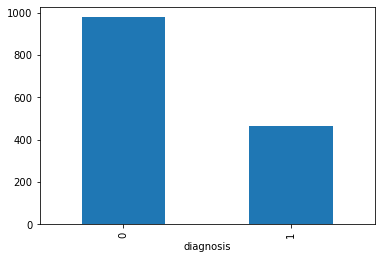

In [23]:
df_count = df.groupby('diagnosis')['area_mean'].mean()
df_count.plot(kind = 'bar')

In [24]:
df[worst_features].describe()

radius_worst  texture_worst  perimeter_worst   area_worst  \
count    569.000000     569.000000       569.000000   569.000000   
mean      16.269190      25.677223       107.261213   880.583128   
std        4.833242       6.146258        33.602542   569.356993   
min        7.930000      12.020000        50.410000   185.200000   
25%       13.010000      21.080000        84.110000   515.300000   
50%       14.970000      25.410000        97.660000   686.500000   
75%       18.790000      29.720000       125.400000  1084.000000   
max       36.040000      49.540000       251.200000  4254.000000   

       smoothness_worst  compactness_worst  concavity_worst  \
count        569.000000         569.000000       569.000000   
mean           0.132369           0.254265         0.272188   
std            0.022832           0.157336         0.208624   
min            0.071170           0.027290         0.000000   
25%            0.116600           0.147200         0.114500   
50%            0.131300           0.211900         0.226700   
75%            0.146000           0.339100         0.382900   
max            0.222600           1.058000         1.252000   

       concave_points_worst  symmetry_worst  fractal_dimension_worst  
count            569.000000      569.000000               569.000000  
mean               0.114606        0.290076                 0.083946  
std                0.065732        0.061867                 0.018061  
min                0.000000        0.156500                 0.055040  
25%                0.064930        0.250400                 0.071460  
50%                0.099930        0.282200                 0.080040  
75%                0.161400        0.317900                 0.092080  
max                0.291000        0.663800                 0.207500

## Correlation/Heatmap

This is a heatmap of the above information that makes it easier to see the features
that correlate with each other.  As you can see, there are many potential correlations 
to explore.  The highest at .99 are: 
- radius_mean : area_mean, and
- perimeter_mean : area_mean. 

I would be curious to run a feature optimization on the data to see if it has similar results.

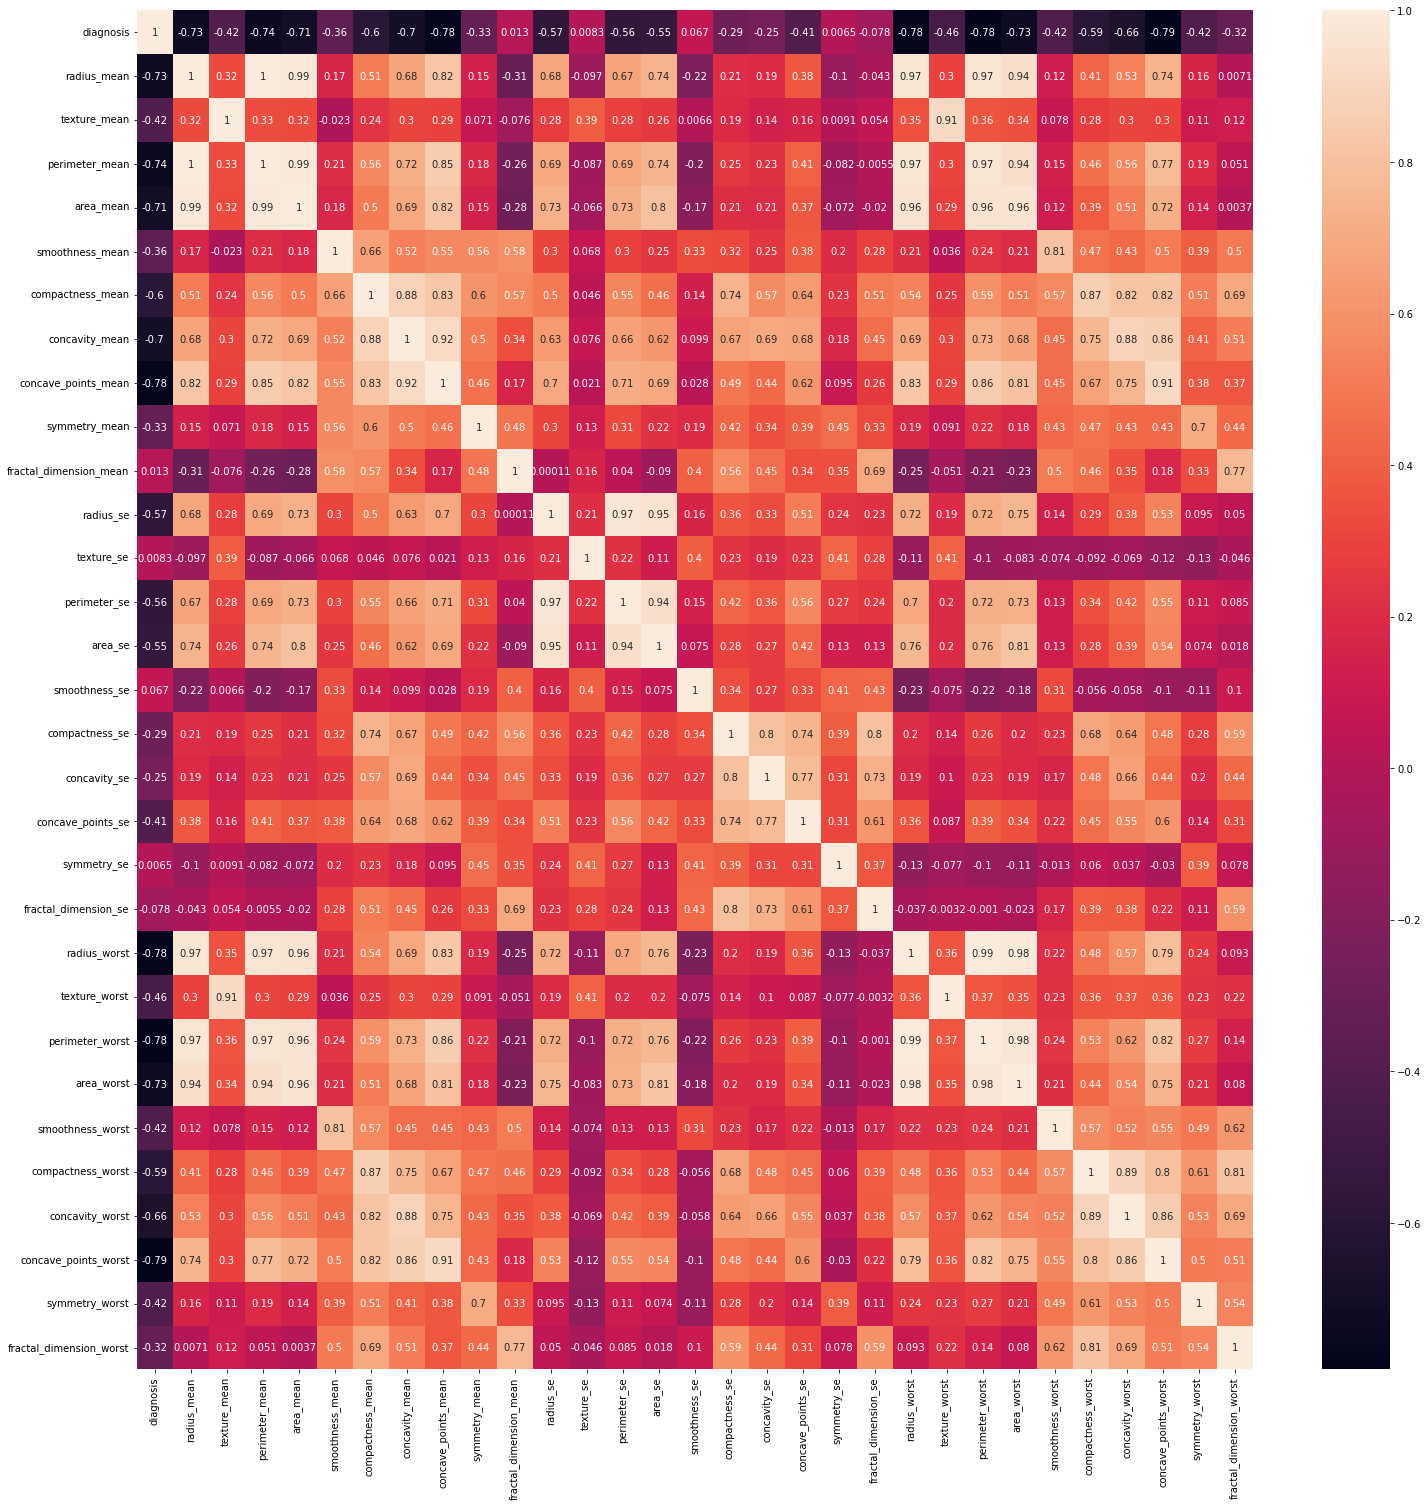

In [25]:
df_corr = df.drop(columns = ['id'])
plt.figure(figsize = (25,25))
sns.heatmap(df_corr.corr(), annot=True)
plt.show()

**Observations:**
The columns that are the lightest indicate the greatest correlation with diagnosis.  I will be using all these columns to predict our result and try feature optimisation as well and eliminate categories to see if the accuracy improves!

**Assumptions:**
Perimeter, radius, and area can be similar measurements, if it is a large area, it will most likely have a large perimeter and large radius. I will use area for the EDA.

**General:**<br>
Precision = TP/(TP+FP)<br>
Recall = TP/(TP+FN)

- **Precision** deals with the Predicted row of the confusion matrix, telling us how accurate the model was in predicting the positive samples out of all the samples predicted to be positive. 
- **Recall** deals with the Expected column of the confusion matrix, telling us how accurately the model was able to identify the positive samples out of all positive samples that were actually present.

# Define X and Y and split Train/Test

In [26]:
X = df.drop(['id','diagnosis'], axis = 1)
y = df['diagnosis']

## Data Engineering

In [27]:
object= StandardScaler() 
 
# standardization to deal with the outliers
X_scaler = pd.DataFrame(object.fit_transform(X), columns = X.columns) 

In [28]:
X_scaler.to_csv('./data/X_scaler.csv')

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_scaler,y, test_size = .20, random_state = 12, stratify = y)

In [30]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((455, 30), (114, 30), (455,), (114,))

In [31]:
X_train.head()

radius_mean  texture_mean  perimeter_mean  area_mean  smoothness_mean  \
494    -0.274725      0.290965       -0.325775  -0.330454        -1.637537   
97     -1.232704      0.151341       -1.229900  -1.024984         0.429819   
528    -0.053194     -1.424083       -0.068336  -0.172606         2.023925   
359    -1.332393     -0.225644       -1.324225  -1.070205         0.323071   
352     3.295334     -0.425771        3.387110   3.854074         1.319387   

     compactness_mean  concavity_mean  concave_points_mean  symmetry_mean  \
494         -0.977725       -0.888883            -0.937847      -0.360051   
97          -0.972798       -1.029135            -1.057093      -1.685343   
528         -0.128699        0.153179             0.444452       0.600147   
359         -0.848666       -0.774633            -0.899156      -1.115796   
352          2.500819        3.113641             3.672569       0.527128   

     fractal_dimension_mean  ...  radius_worst  texture_worst  \
494               -0.555362  ...     -0.366368       0.453158   
97                 0.865077  ...     -1.107724       0.099787   
528                0.251255  ...     -0.341518      -1.676839   
359                0.962892  ...     -0.879933      -0.107025   
352               -0.225060  ...      3.491579      -0.341520   

     perimeter_worst  area_worst  smoothness_worst  compactness_worst  \
494        -0.356573   -0.408333         -0.901643          -0.570395   
97         -1.145302   -0.904416         -0.033692          -1.014866   
528        -0.379508   -0.399544          0.308228          -0.749786   
359        -0.937396   -0.775210          0.040829          -0.950170   
352         3.635028    4.137101          0.904396           2.159281   

     concavity_worst  concave_points_worst  symmetry_worst  \
494        -0.936517             -1.106307       -0.345810   
97         -1.207529             -1.382518       -1.563999   
528        -0.557897             -0.199563       -1.198380   
359        -0.756994             -0.975815       -0.722753   
352         1.789052              2.451387        1.276824   

     fractal_dimension_worst  
494                -0.535085  
97                  0.328848  
528                -0.632617  
359                -0.143295  
352                 0.232978  

[5 rows x 30 columns]

I will run a Random Forest Classification Model as my baseline and then I will do a Logistic Regression Model with feature optimisation to see if I can get better results.

# Random Forest Classification Model 

## Grid Search - Hyperperameter Optimization

I have removed the following to improve run times.  I ran it once and recorded the results.  To re-run, just use escape y to turn back on (escape r to remove).

## Running the Model

In [32]:
rfc = RandomForestClassifier(max_depth=8, n_estimators=4 , random_state = 12)

Training Scores
       Score   Results
0   accuracy  1.000000
1  precision  0.996466
2     recall  0.989474
3         f1  0.992958
Test Scores
       Score   Results
0   accuracy  1.000000
1  precision  0.956522
2     recall  0.916667
3         f1  0.936170


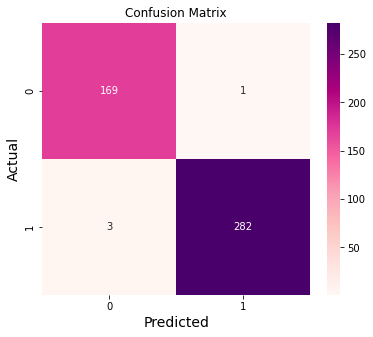

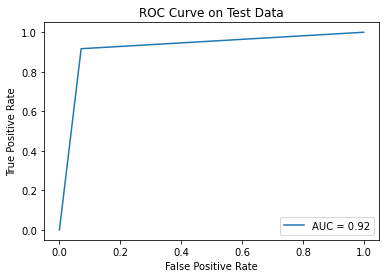

The ROC and AUC are run on the test data after the model has been trained.


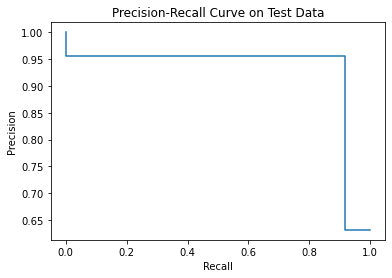

In [33]:
rfc_run = ml_function(rfc, X_train, y_train, X_test, y_test)
rfc_run

## Feature Elimination

### Feature Importances SKlearn

In [34]:
importance = rfc.feature_importances_.argsort()
# summarize feature importance
for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,   v))

Feature: 0, Score: 5.00000
Feature: 1, Score: 11.00000
Feature: 2, Score: 25.00000
Feature: 3, Score: 10.00000
Feature: 4, Score: 3.00000
Feature: 5, Score: 17.00000
Feature: 6, Score: 6.00000
Feature: 7, Score: 28.00000
Feature: 8, Score: 12.00000
Feature: 9, Score: 14.00000
Feature: 10, Score: 16.00000
Feature: 11, Score: 19.00000
Feature: 12, Score: 18.00000
Feature: 13, Score: 24.00000
Feature: 14, Score: 29.00000
Feature: 15, Score: 1.00000
Feature: 16, Score: 2.00000
Feature: 17, Score: 26.00000
Feature: 18, Score: 22.00000
Feature: 19, Score: 9.00000
Feature: 20, Score: 8.00000
Feature: 21, Score: 21.00000
Feature: 22, Score: 4.00000
Feature: 23, Score: 15.00000
Feature: 24, Score: 7.00000
Feature: 25, Score: 20.00000
Feature: 26, Score: 13.00000
Feature: 27, Score: 0.00000
Feature: 28, Score: 23.00000
Feature: 29, Score: 27.00000


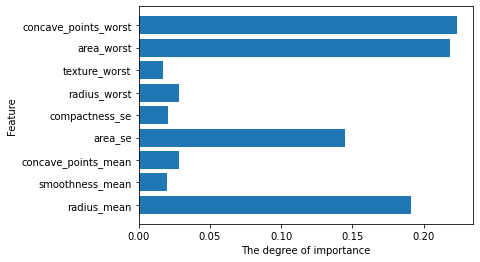

In [35]:
sorted_idx = rfc.feature_importances_> 0.015
plt.barh(X_train.columns[sorted_idx], rfc.feature_importances_[sorted_idx])
plt.yticks(np.arange(sum(sorted_idx)), X_train.columns[sorted_idx])
plt.xlabel("The degree of importance")
plt.ylabel("Feature")
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

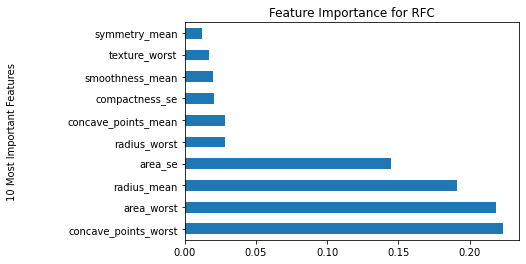

In [36]:
feat_importances = pd.Series(rfc.feature_importances_, index=X_train.columns)
data_feat = feat_importances.nlargest(10).plot(kind='barh')
plt.title("Feature Importance for RFC")
plt.ylabel("10 Most Important Features", labelpad = 50)
plt.savefig("./images/rfc_features.png", bbox_inches='tight')
plt.show



### SHAP Analysis Feature Importances

SHAP values help quantify a feature’s contribution towards a prediction. If the value is closer to zero then the feature contributes very little to the prediction.  If the value is farther away from zero, this indicates that the feature contributes more to the prediction.

In [37]:
explainer = shap.TreeExplainer(rfc)
shap_values = explainer.shap_values(X_test)

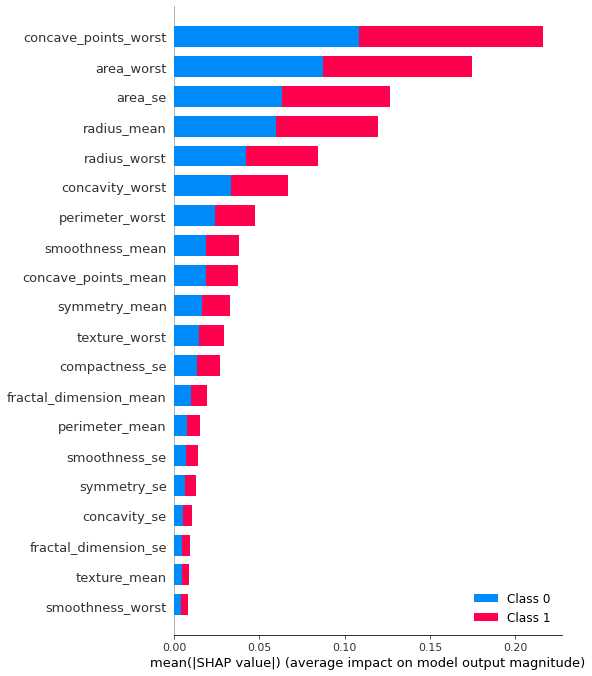

In [38]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

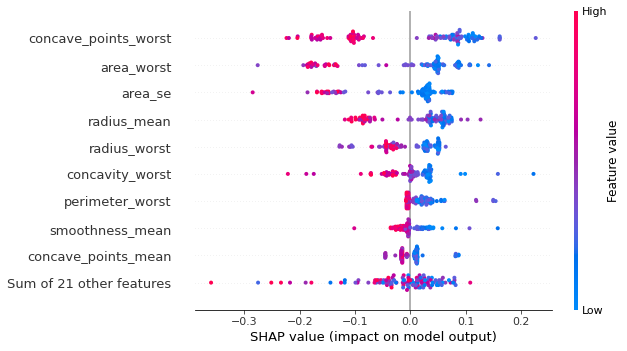

In [39]:
explainer = Explainer(rfc)
sv = explainer(X_test)

beeswarm(sv[:,:,1])

## Conclusion

**Conclusion:**  We will reduce the features to include the top 10 features per SKlearn and the top 9 from SHAP analysis which gives us the following 12 features:
- 'radius_mean','smoothness_mean','concave_points_mean', 'symmetry_mean', 'area_se', 'compactness_se', 'radius_worst', 'texture_worst','perimeter_worst', 'area_worst', 'concavity_worst', 'concave_points_worst'

In [40]:
#after feature removal, there are 8 columns
X_train_fr_rfc = X_train[['radius_mean','smoothness_mean','concave_points_mean', 'symmetry_mean', 'area_se', 'compactness_se', 'radius_worst', 'texture_worst','perimeter_worst', 'area_worst', 'concavity_worst', 'concave_points_worst']]
X_train_fr_rfc.shape

(455, 12)

In [41]:
X_train_fr_rfc.head(2)

radius_mean  smoothness_mean  concave_points_mean  symmetry_mean  \
494    -0.274725        -1.637537            -0.937847      -0.360051   
97     -1.232704         0.429819            -1.057093      -1.685343   

     area_se  compactness_se  radius_worst  texture_worst  perimeter_worst  \
494 -0.31390       -0.277108     -0.366368       0.453158        -0.356573   
97  -0.44635       -0.606297     -1.107724       0.099787        -1.145302   

     area_worst  concavity_worst  concave_points_worst  
494   -0.408333        -0.936517             -1.106307  
97    -0.904416        -1.207529             -1.382518

In [42]:
#need to make the test data match the training data
X_test_fr_rfc = X_test[['radius_mean','smoothness_mean','concave_points_mean', 'symmetry_mean', 'area_se', 'compactness_se', 'radius_worst', 'texture_worst','perimeter_worst', 'area_worst', 'concavity_worst', 'concave_points_worst']]

In [43]:
X_train_fr_rfc.to_csv('./data/X_train_rfc_feature_elim.csv')
X_test_fr_rfc.to_csv('./data/X_test_rfc_feature_elim.csv')
y_train.to_csv('./data/y_train.csv')
y_test.to_csv('./data/y_test.csv')

# RFC with Reduced Features

In [44]:
rfc2 = RandomForestClassifier(n_estimators=4, max_depth=8, random_state = 12)#, oob_score=True) 

Training Scores
       Score   Results
0   accuracy  1.000000
1  precision  1.000000
2     recall  0.985965
3         f1  0.992933
Test Scores
       Score   Results
0   accuracy  1.000000
1  precision  0.969697
2     recall  0.888889
3         f1  0.927536


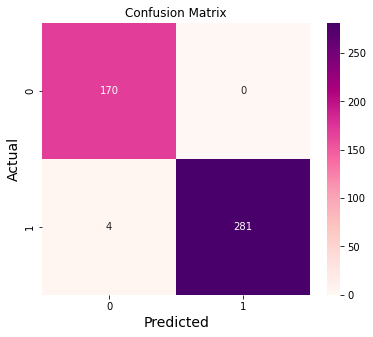

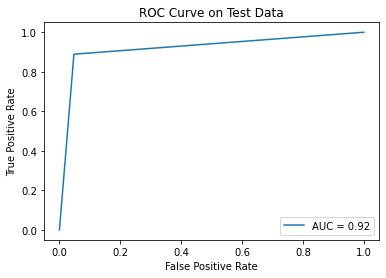

The ROC and AUC are run on the test data after the model has been trained.


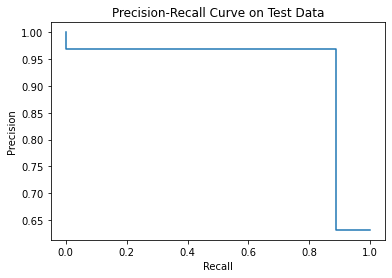

In [45]:
rfc2_run = ml_function(rfc2, X_train_fr_rfc, y_train, X_test_fr_rfc, y_test)
rfc2_run

## Visualisation of RFC Trees

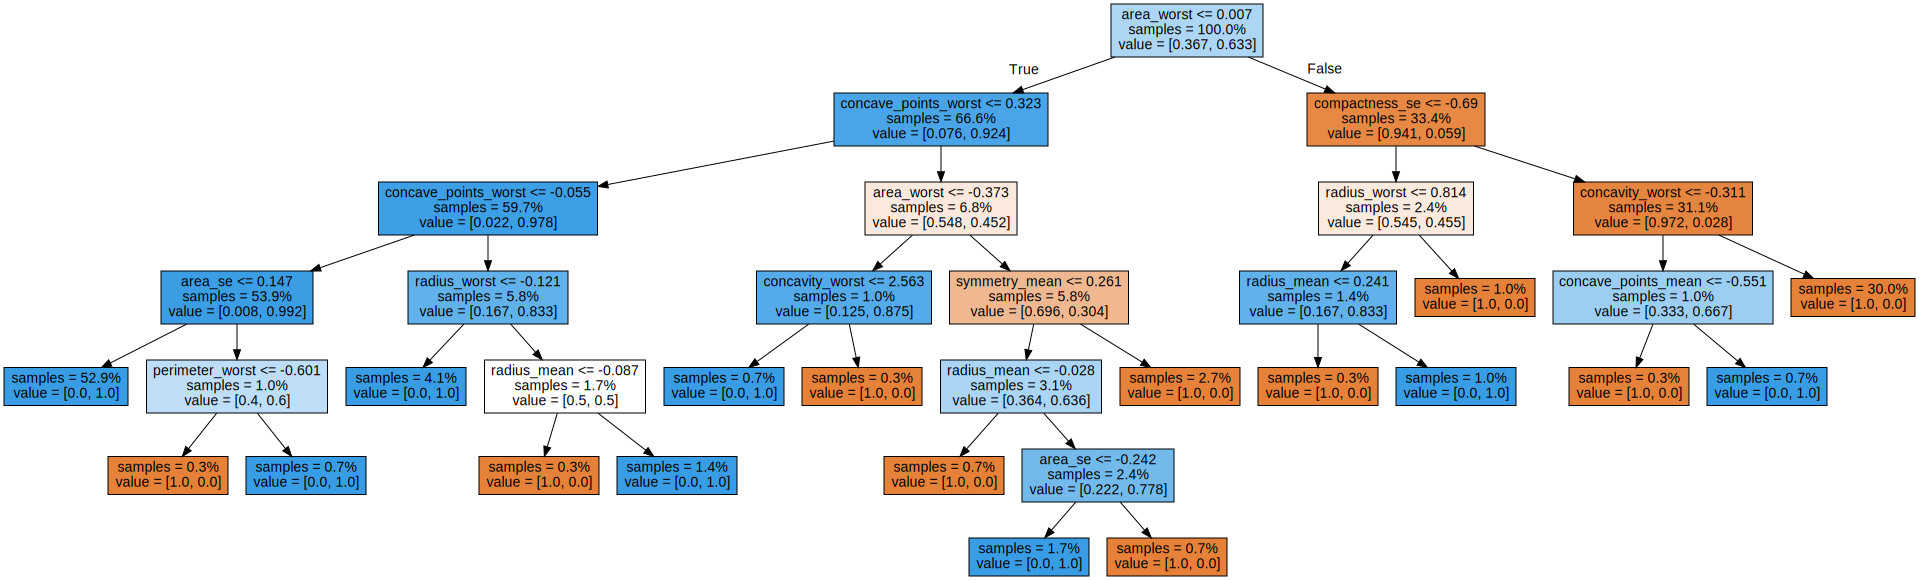

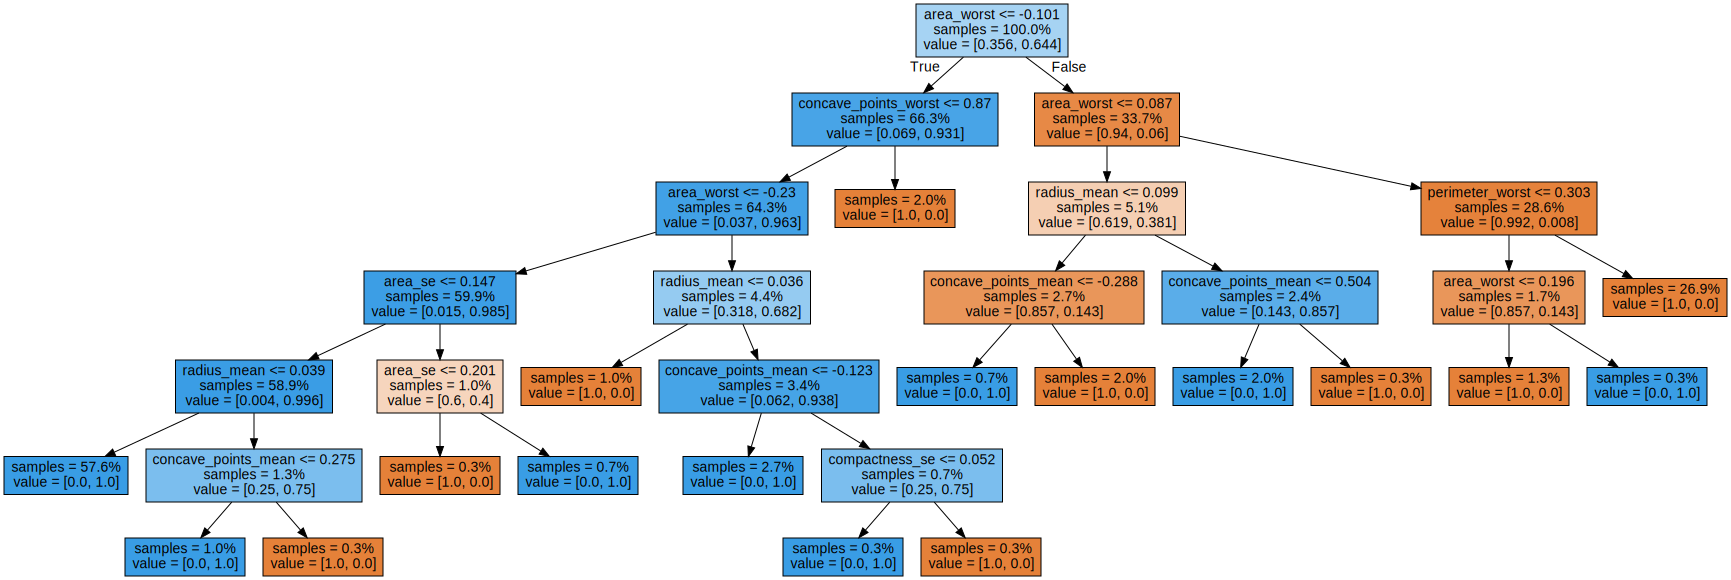

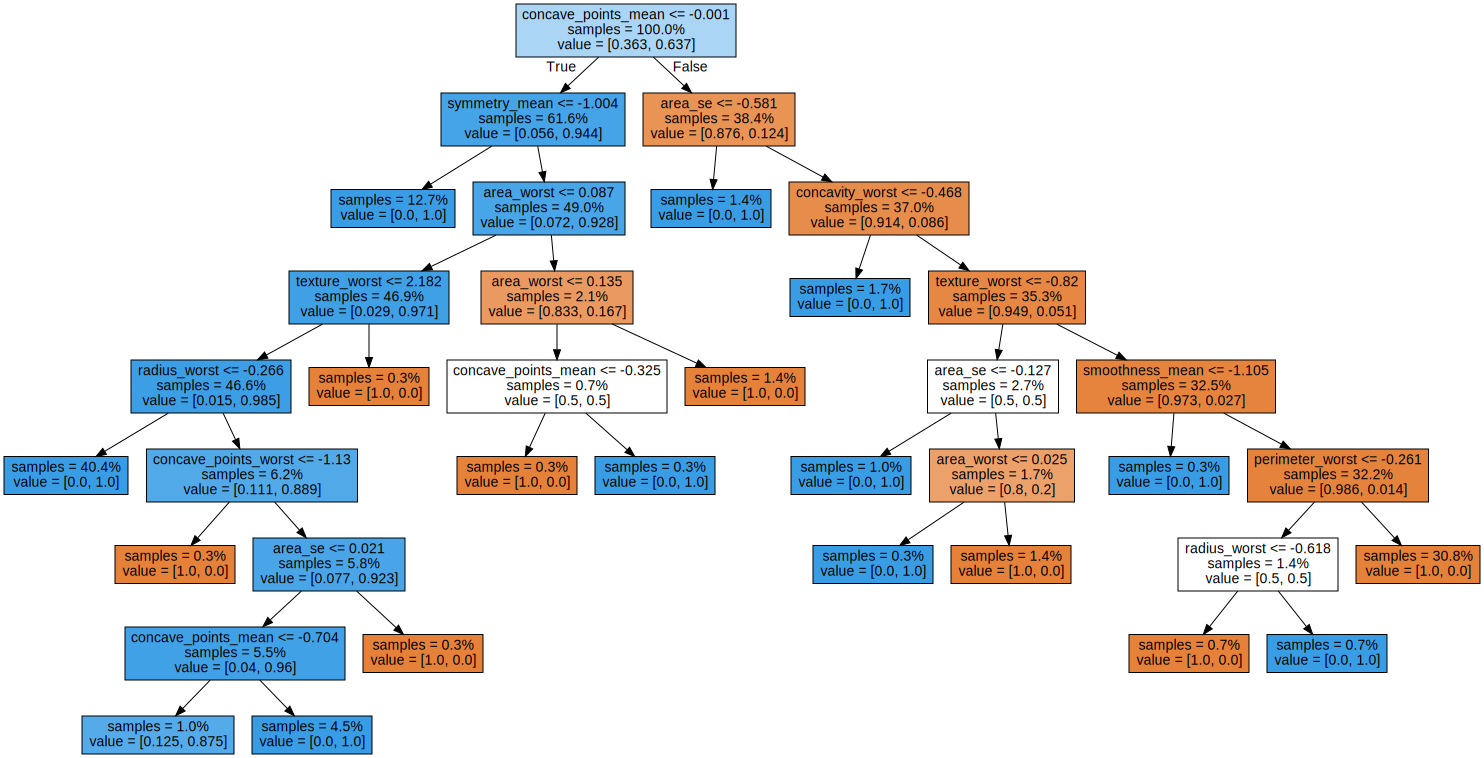

In [46]:
for i in range(3):
    tree = rfc2.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train_fr_rfc.columns,  
                               filled=True,  
                               max_depth=8, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

## RFC with Cross Validation

In [47]:
cross_val = cross_val_score(estimator=rfc2,
                            X=X_train_fr_rfc,
                            y=y_train,
                            cv=5,
                            scoring = 'precision'

)
cross_val

array([1.        , 0.94642857, 0.95      , 0.93442623, 0.96551724])

In [48]:
cross_val.mean()

0.9592744084632157

## Conclusion

Because the score for the test values is lower than the training values, this indicates that the model is overfitting.

# Logistic Regression

## Logistic Regression on Full Training Set

I chose the solver liblinear for the model as it is a small-ish data set and a binary classification.  The penalties that work with liblinear are L1 or L2.  I also tried the option class_weight='balanced' to even out the bias caused by the non-malignant outnumbering the benign. The loss function should return high values for bad predictions and low values for good predictions.

**liblinear defaults:** multi_class defaults to 'ovr' and loss_function is L1, L2.
- A Loss Function takes the true target values ytrain and the current predictions ypred and returns a single number. The closer that number to zero, the better the fit.
- **L1** loss function is also known as Least Absolute Deviations. L1 is more resistent to outliers and overfitting.
- **L2** loss function is also known as Least square errors.  Which is the squared difference between a prediction and the actual value, calculated for each example in the dataset

In [49]:
lr = LogisticRegression(solver='liblinear', random_state = 12)#, class_weight = 'balanced', ) 

In [50]:
def lr_model(model, X_train_data, y_train_data, X_test_data, y_test_data):
    model.fit(X_train_data, y_train_data)
    y_train_pred = model.predict(X_train_data)
    results_model_train = pd.DataFrame({
        'Score': ['accuracy', 'precision', 'recall', 'f1'],
        'Results': [model.score(X_train_data, y_train_pred), precision_score(y_train_data, y_train_pred), recall_score(y_train_data, y_train_pred), f1_score(y_train_data, y_train_pred)]})
    print("Training Scores")
    print(results_model_train)
    conf_model = confusion_matrix(y_train_data, y_train_pred)
    plot_heatmap(conf_model)
    y_test_pred = model.predict(X_test_data)
    
    results_model_test = pd.DataFrame({
        'Score': ['accuracy', 'precision', 'recall', 'f1'],
        'Results': [model.score(X_test_data, y_test_pred), precision_score(y_test_data, y_test_pred), recall_score(y_test_data, y_test_pred), f1_score(y_test_data, y_test_pred)]})
    print("Test Scores")
    print(results_model_test)
    
    fpr, tpr, thresholds = metrics.roc_curve(y_test_data, y_test_pred)
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
    display.plot()
    plt.title('ROC Curve on Test Data')
    plt.show()
    print("The ROC and AUC are run on the test data after the model has been trained.")

    precision, recall, _ = precision_recall_curve(y_test, y_test_pred)
    disp = PrecisionRecallDisplay(precision=precision, recall=recall)
    disp.plot()
    plt.title('Precision-Recall Curve on Test Data')
    plt.show()

Training Scores
       Score   Results
0   accuracy  1.000000
1  precision  0.986063
2     recall  0.992982
3         f1  0.989510
Test Scores
       Score   Results
0   accuracy  1.000000
1  precision  0.986301
2     recall  1.000000
3         f1  0.993103


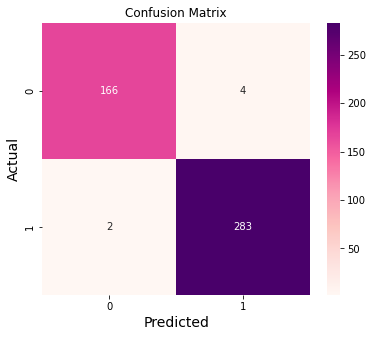

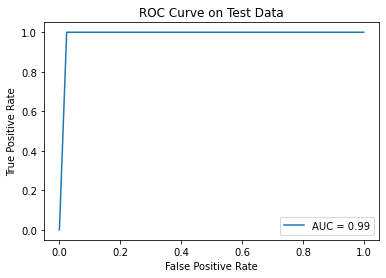

The ROC and AUC are run on the test data after the model has been trained.


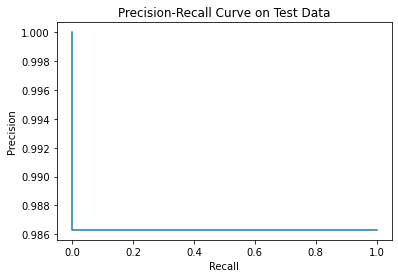

In [51]:
lr_run = lr_model(lr, X_train, y_train, X_test, y_test)
lr_run

### Feature Importance - Logistic Regression

In [52]:
importance = lr.coef_[0]

<function matplotlib.pyplot.show(close=None, block=None)>

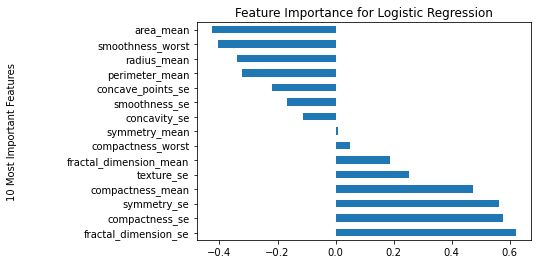

In [53]:
feat_importances = pd.Series(importance, index=X_train.columns)
feat_importances.nlargest(15).plot(kind='barh',title = 'Feature Importance') 
plt.title("Feature Importance for Logistic Regression")
plt.ylabel("10 Most Important Features", labelpad = 50)
plt.savefig("./images/lr_features.png", bbox_inches='tight')
plt.show

In [54]:
#The positive scores indicate a feature that predicts class 1,
#whereas the negative scores indicate a feature that predicts class 0.
for i,v in enumerate(importance):
  print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: -0.34041
Feature: 1, Score: -0.47352
Feature: 2, Score: -0.32250
Feature: 3, Score: -0.42648
Feature: 4, Score: -0.42723
Feature: 5, Score: 0.47224
Feature: 6, Score: -0.69248
Feature: 7, Score: -1.07949
Feature: 8, Score: 0.00703
Feature: 9, Score: 0.18603
Feature: 10, Score: -1.20473
Feature: 11, Score: 0.25427
Feature: 12, Score: -0.65683
Feature: 13, Score: -0.96483
Feature: 14, Score: -0.16734
Feature: 15, Score: 0.57673
Feature: 16, Score: -0.11162
Feature: 17, Score: -0.22039
Feature: 18, Score: 0.56369
Feature: 19, Score: 0.62219
Feature: 20, Score: -0.96396
Feature: 21, Score: -1.06385
Feature: 22, Score: -0.74932
Feature: 23, Score: -0.97680
Feature: 24, Score: -0.40537
Feature: 25, Score: 0.04930
Feature: 26, Score: -0.78789
Feature: 27, Score: -0.83997
Feature: 28, Score: -0.82372
Feature: 29, Score: -0.43609


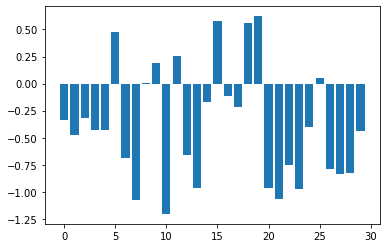

In [55]:
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

<AxesSubplot:ylabel='Feature'>

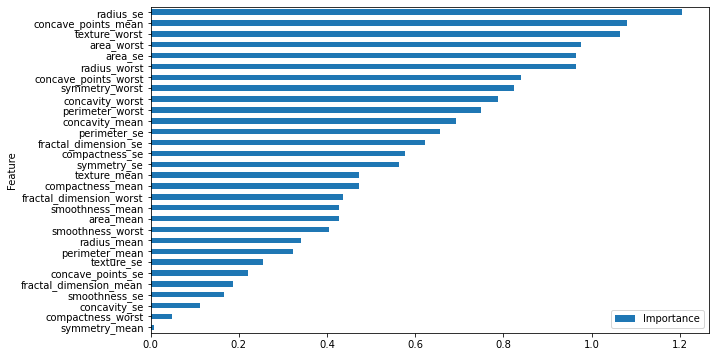

In [56]:
coefficients = lr.coef_[0]

feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

## SHAP Analysis on Logistic Regression Model

In [57]:
explainer = shap.LinearExplainer(lr, X_test)
shap_values = explainer.shap_values(X_test)

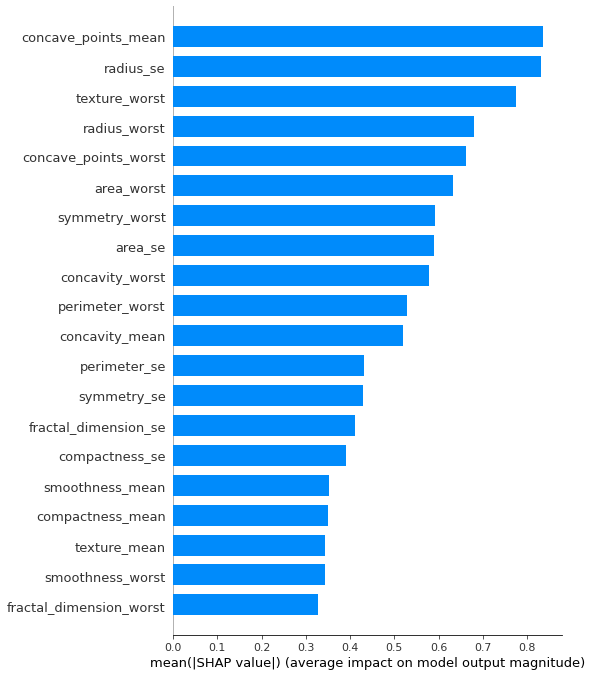

In [58]:
#shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

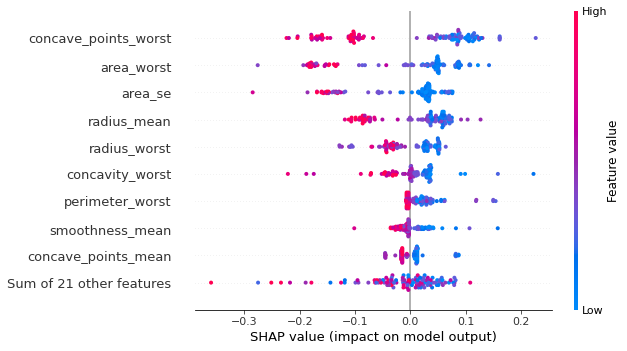

In [59]:
explainer = shap.LinearExplainer(lr, X_train)
shap_values = explainer(X_test)

beeswarm(sv[:,:,1])

## Conclusion

**Conclusion:** We will keep the sample size similar to the RFC model (12 features) for our prediction model on our app.

## Features Eliminated

In [60]:
#new X for prediction on app
X_LR_feature_reduction = X[['concavity_mean','concave_points_mean', 'radius_se', 
        'perimeter_se','area_se', 'radius_worst', 'texture_worst','perimeter_worst', 
        'area_worst', 'concavity_worst', 'concave_points_worst','symmetry_worst']]
X_LR_feature_reduction.shape

(569, 12)

In [61]:
#after feature removal, there are 13 columns
X_train_lr = X_train[['concavity_mean','concave_points_mean', 'radius_se', 
        'perimeter_se','area_se', 'radius_worst', 'texture_worst','perimeter_worst', 
        'area_worst', 'concavity_worst', 'concave_points_worst','symmetry_worst']]
X_train_lr.shape

(455, 12)

In [62]:
#after feature removal, there are 13 columns
X_test_lr = X_test[['concavity_mean','concave_points_mean', 'radius_se', 
        'perimeter_se','area_se', 'radius_worst', 'texture_worst','perimeter_worst', 
        'area_worst', 'concavity_worst', 'concave_points_worst','symmetry_worst']]
X_test_lr.shape

(114, 12)

In [63]:
X_LR_feature_reduction.to_csv('./data/X_LR_feature_reduction.csv')
X_train_lr.to_csv('./data/X_train_lr.csv')
X_test_lr.to_csv('./data/X_test_lr.csv')

In [64]:
X_LR_feature_reduction.columns

Index(['concavity_mean', 'concave_points_mean', 'radius_se', 'perimeter_se',
       'area_se', 'radius_worst', 'texture_worst', 'perimeter_worst',
       'area_worst', 'concavity_worst', 'concave_points_worst',
       'symmetry_worst'],
      dtype='object')

## Train New LR Model with eliminated features

In [65]:
lr2 = LogisticRegression(solver='liblinear', random_state = 12)#, class_weight = 'balanced', ) 

Training Scores
       Score   Results
0   accuracy  1.000000
1  precision  0.972414
2     recall  0.989474
3         f1  0.980870
Test Scores
       Score   Results
0   accuracy  1.000000
1  precision  0.972222
2     recall  0.972222
3         f1  0.972222


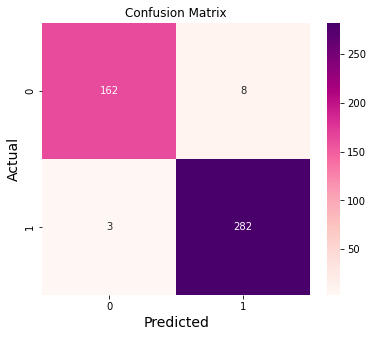

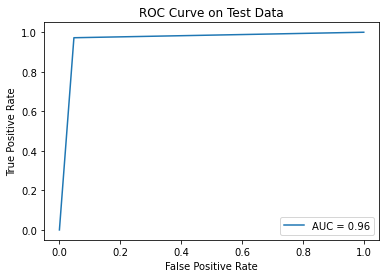

The ROC and AUC are run on the test data after the model has been trained.


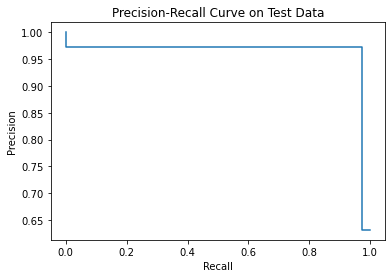

In [66]:
lr2_run = ml_function(lr2, X_train_lr, y_train, X_test_lr, y_test)
lr2_run

In [67]:
pickle.dump(lr2, open('./model/lr2.pkl', 'wb'))

### Conclusion 

The test score is closer to the training score.  This is better than the Random Forest Classifier (model is not overfitting as much).

# Support Vector Machine

In [68]:
svm = SVC(decision_function_shape='ovo', probability=True)

Training Scores
       Score   Results
0   accuracy  1.000000
1  precision  0.979167
2     recall  0.989474
3         f1  0.984293
Test Scores
       Score   Results
0   accuracy  1.000000
1  precision  0.971831
2     recall  0.958333
3         f1  0.965035


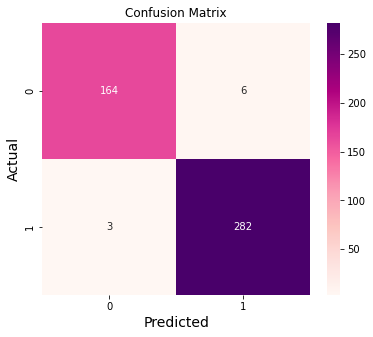

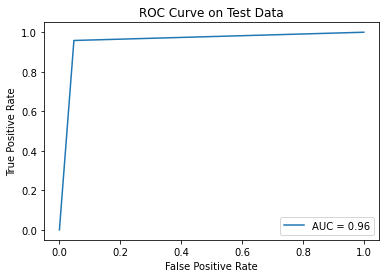

The ROC and AUC are run on the test data after the model has been trained.


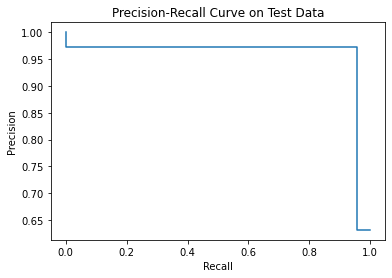

In [69]:
svm_run = ml_function(svm,  X_train_lr, y_train, X_test_lr, y_test)

# Ensemble Models

In [70]:
models = [
          ('logreg', LogisticRegression(solver='liblinear')),
          ('tree', DecisionTreeClassifier()),
          ('svm', SVC(kernel='rbf', probability=True))
]
em = VotingClassifier(models, voting = 'soft')

Training Scores
       Score   Results
0   accuracy  1.000000
1  precision  0.989547
2     recall  0.996491
3         f1  0.993007
Test Scores
       Score   Results
0   accuracy  1.000000
1  precision  0.971429
2     recall  0.944444
3         f1  0.957746


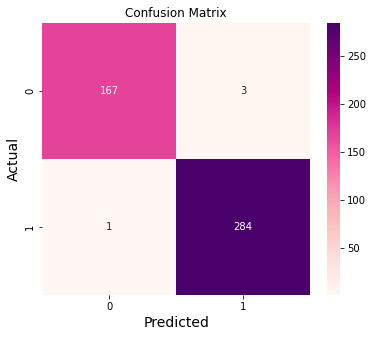

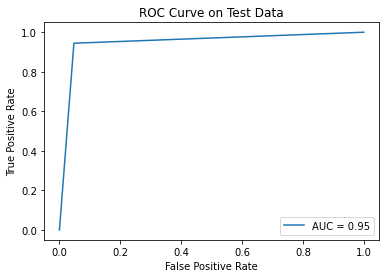

The ROC and AUC are run on the test data after the model has been trained.


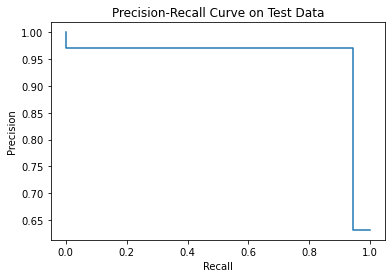

In [71]:
em_run = ml_function(em,  X_train_lr, y_train, X_test_lr, y_test)

## ROC and AUC

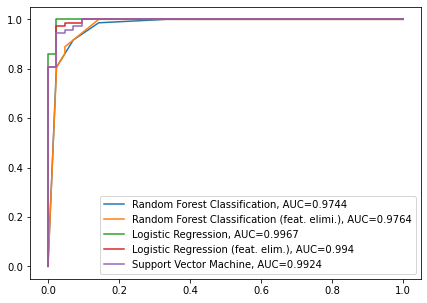

In [72]:
plt.figure(figsize=(7,5))

y_pred = rfc.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Random Forest Classification, AUC="+str(auc))

y_pred = rfc2.predict_proba(X_test_fr_rfc)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Random Forest Classification (feat. elimi.), AUC="+str(auc))

y_pred = lr.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Logistic Regression, AUC="+str(auc))

y_pred = lr2.predict_proba(X_test_lr)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Logistic Regression (feat. elim.), AUC="+str(auc))

y_pred = svm.predict_proba(X_test_lr)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Support Vector Machine, AUC="+str(auc))

#y_pred = em.predict_proba(X_test_lr)[:, 1]
#fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
#auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
#plt.plot(fpr,tpr,label="Ensemble Model, AUC="+str(auc))

plt.legend()
plt.savefig("./images/All_Models_ROC.png")

<Figure size 720x1080 with 0 Axes>

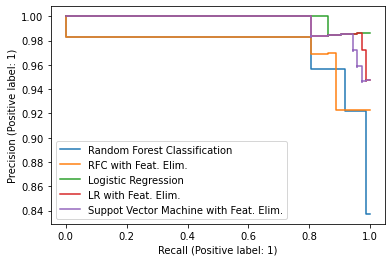

In [73]:
plt.figure(figsize=(10,15))
fig, ax = plt.subplots()


PrecisionRecallDisplay.from_estimator(rfc, X_test, y_test, ax=ax,label = "Random Forest Classification")
PrecisionRecallDisplay.from_estimator(rfc2, X_test_fr_rfc, y_test, ax=ax, label = "RFC with Feat. Elim.")
PrecisionRecallDisplay.from_estimator(lr, X_test, y_test, ax=ax, label = "Logistic Regression")
PrecisionRecallDisplay.from_estimator(lr2, X_test_lr, y_test, ax=ax, label = "LR with Feat. Elim.")
PrecisionRecallDisplay.from_estimator(svm, X_test_lr, y_test, ax=ax, label = "Suppot Vector Machine with Feat. Elim.")
#PrecisionRecallDisplay.from_estimator(em, X_test_lr, y_test, ax=ax, label = "Ensemble Model with Feat. Elim.")

plt.savefig("./images/All_Models_precisionrecall.png", bbox_inches='tight')
plt.show()
